d:\fraud\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing SHAP values… this may take a few minutes.


d:\fraud\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


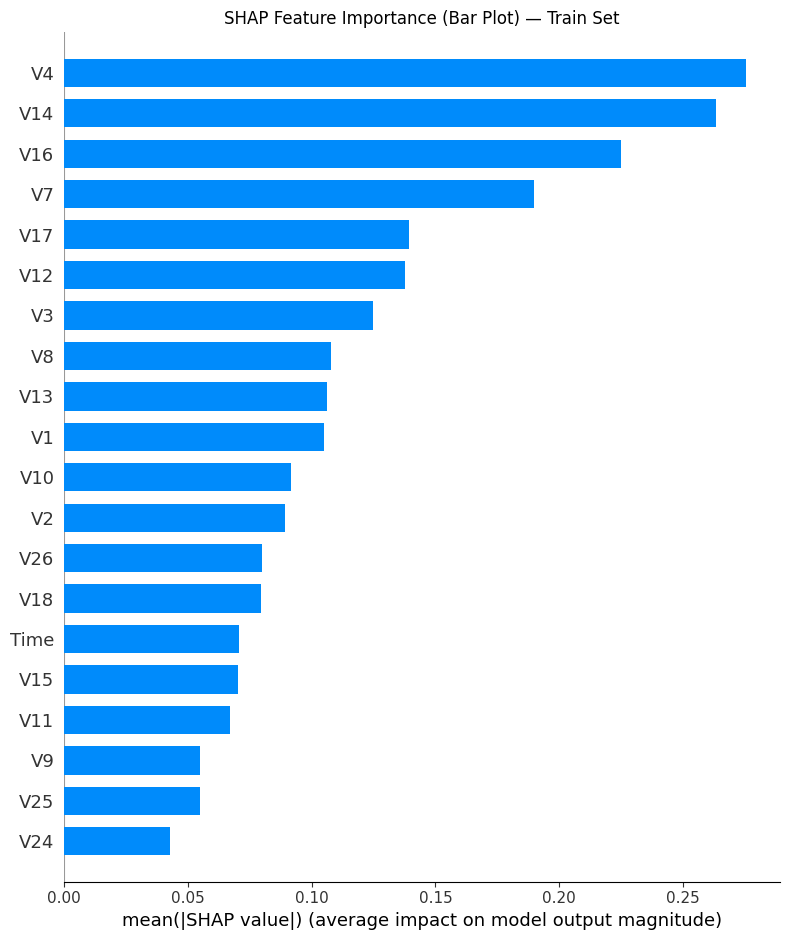

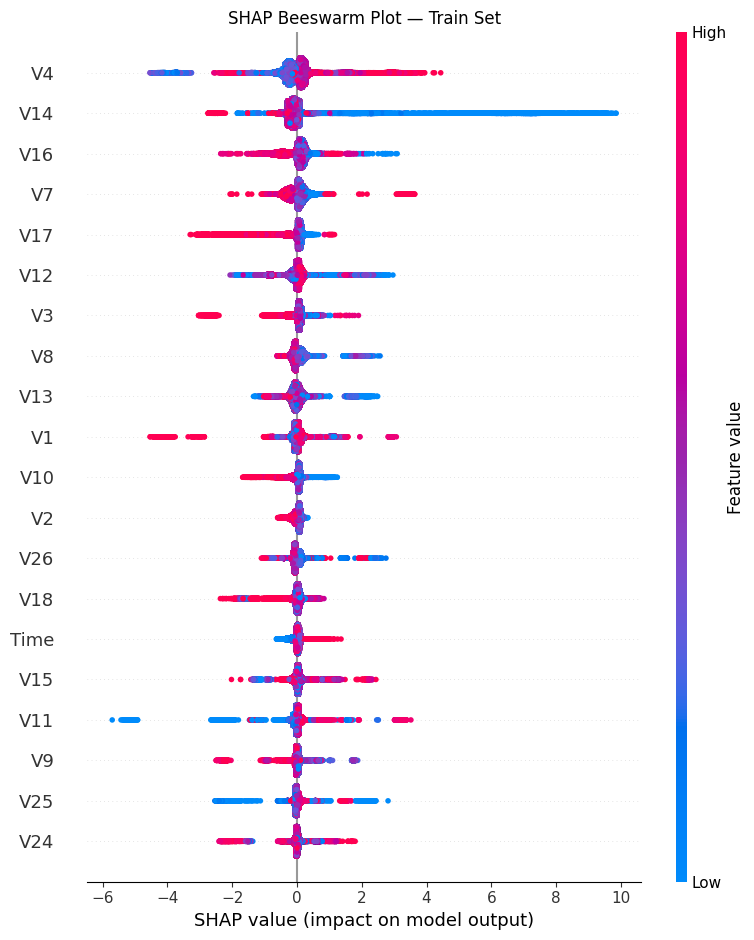

Plots saved: shap_bar_train.png & shap_beeswarm_train.png


In [1]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt

# Load data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze()  # if saved as single-column CSV

# Load trained model
model = joblib.load("final_fraud_model_lgbm.pkl")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
print("Computing SHAP values… this may take a few minutes.")
shap_values = explainer.shap_values(X_train)


shap_vals_fraud = shap_values


# Bar plot: mean(|SHAP|) — feature importance
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_vals_fraud, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot) — Train Set")
plt.tight_layout()
plt.savefig("shap_bar_train.png")
plt.show()

# Beeswarm plot: feature values and SHAP impact
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_vals_fraud, X_train, show=False)
plt.title("SHAP Beeswarm Plot — Train Set")
plt.tight_layout()
plt.savefig("shap_beeswarm_train.png")
plt.show()

print("Plots saved: shap_bar_train.png & shap_beeswarm_train.png")


In [2]:
print(type(shap_values))
print(len(shap_values))


<class 'numpy.ndarray'>
213605


Top features: ['V4', 'V14', 'V16', 'V7', 'V17']


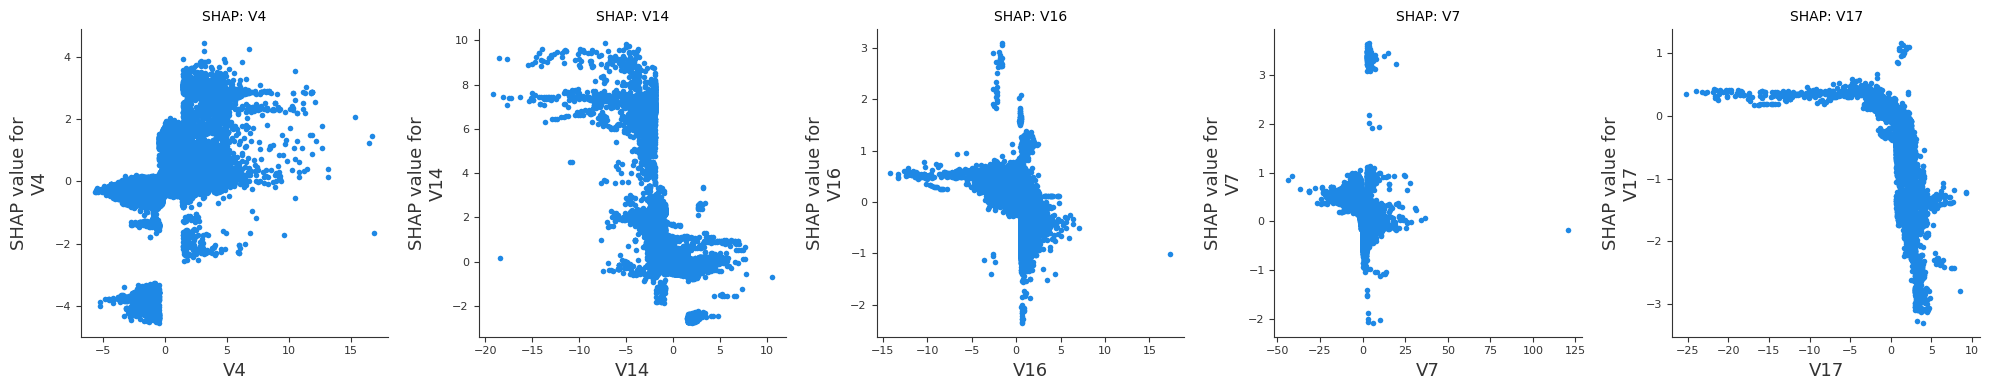

 Saved: shap_dependence_top5.png


In [3]:
import matplotlib.pyplot as plt
import shap
import pandas as pd

# Assumes you already have:
# X_train: your training DataFrame
# shap_vals_fraud: SHAP values ndarray of shape (n_samples, n_features)

# Check if SHAP values are loaded
assert 'shap_vals_fraud' in globals(), "shap_vals_fraud not found. Run explainer.shap_values() first."
assert 'X_train' in globals(), "X_train not found. Load X_train.csv first."

# Compute mean(|SHAP|) to find top features
mean_abs_shap = pd.Series(
    abs(shap_vals_fraud).mean(axis=0), 
    index=X_train.columns
).sort_values(ascending=False)

top_features = mean_abs_shap.index[:5].tolist()
print(f"Top features: {top_features}")

# Plot subplots of SHAP dependence
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, 
        shap_vals_fraud, 
        X_train, 
        ax=axes[i], 
        show=False,interaction_index=None
    )
    axes[i].set_title(f"SHAP: {feature}", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.savefig("shap_dependence_top5.png")
plt.show()

print(" Saved: shap_dependence_top5.png")


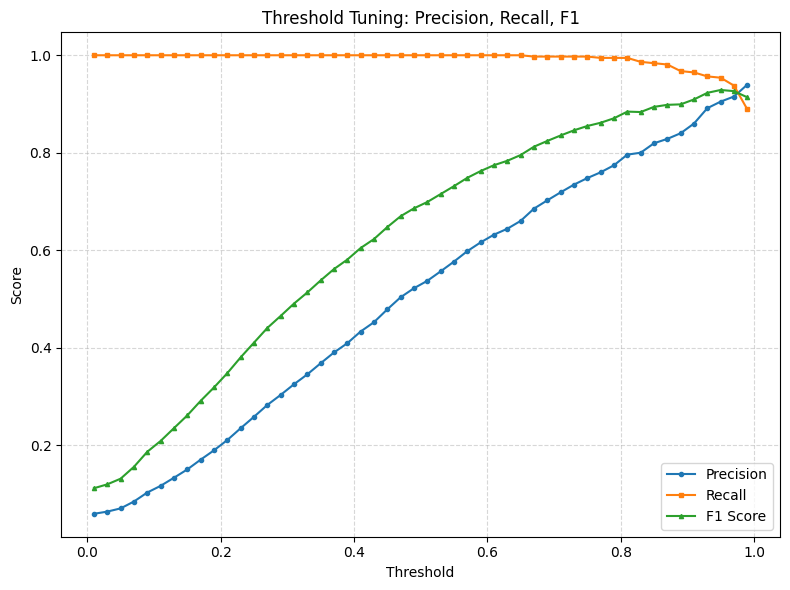

 Best F1 at threshold ≈ 0.95: F1 = 0.929
 Precision: 0.905, Recall: 0.954


(array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
        0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
        0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
        0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
        0.89, 0.91, 0.93, 0.95, 0.97, 0.99]),
 [0.05905889884763124,
  0.06354399862235233,
  0.07015209125475286,
  0.08428506167199634,
  0.102728285077951,
  0.116403785488959,
  0.13302090843547223,
  0.15006100040666936,
  0.17012448132780084,
  0.18923076923076923,
  0.2103762827822121,
  0.23458359821996186,
  0.25804195804195806,
  0.2823259372609028,
  0.30295566502463056,
  0.3248239436619718,
  0.3451824134705332,
  0.3678963110667996,
  0.39006342494714585,
  0.4090909090909091,
  0.43309859154929575,
  0.4522058823529412,
  0.4785992217898833,
  0.5034106412005457,
  0.521923620933522,
  0.537117903930131,
  0.5565610859728507,
  0.5765625,
  0.5980551053484603,
  0.6160267111853088

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_threshold_curves(model, X, y_true, title="Threshold Tuning: Precision, Recall, F1"):
    """
    Plots precision, recall, and F1 score as functions of threshold.
    """
    # Get predicted probabilities
    y_proba = model.predict_proba(X)[:, 1]
    
    # Define thresholds to evaluate
    thresholds = np.linspace(0.01, 0.99, 50)
    precisions = []
    recalls = []
    f1s = []

    # Compute metrics for each threshold
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision', marker='o', markersize=3)
    plt.plot(thresholds, recalls, label='Recall', marker='s', markersize=3)
    plt.plot(thresholds, f1s, label='F1 Score', marker='^', markersize=3)

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("threshold_tuning_curves.png", dpi=150)
    plt.show()

    # Find best F1 threshold
    best_idx = np.argmax(f1s)
    print(f" Best F1 at threshold ≈ {thresholds[best_idx]:.2f}: F1 = {f1s[best_idx]:.3f}")
    print(f" Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}")

    return thresholds, precisions, recalls, f1s


plot_threshold_curves(model, X_train, y_train, title="Threshold Tuning: Precision, Recall, F1")

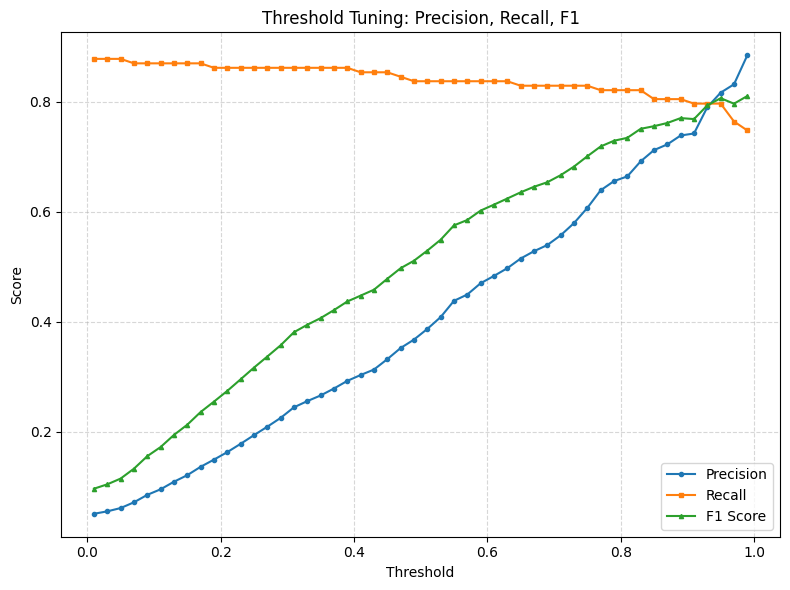

 Best F1 at threshold ≈ 0.99: F1 = 0.811
 Precision: 0.885, Recall: 0.748


(array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
        0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
        0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
        0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
        0.89, 0.91, 0.93, 0.95, 0.97, 0.99]),
 [0.051257712387280496,
  0.05572755417956656,
  0.06167904054825814,
  0.07215104517869184,
  0.08566853482786228,
  0.09579230080572963,
  0.10951893551688843,
  0.12145289443813848,
  0.13665389527458494,
  0.1497175141242938,
  0.1633281972265023,
  0.17845117845117844,
  0.19413919413919414,
  0.20948616600790515,
  0.225531914893617,
  0.24480369515011546,
  0.2560386473429952,
  0.2663316582914573,
  0.2789473684210526,
  0.292817679558011,
  0.30346820809248554,
  0.31343283582089554,
  0.3322784810126582,
  0.3525423728813559,
  0.3678571428571429,
  0.38721804511278196,
  0.4087301587301587,
  0.43829787234042555,
  0.4497816593886463,
  0.

In [5]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

plot_threshold_curves(model, X_test, y_test, title="Threshold Tuning: Precision, Recall, F1")

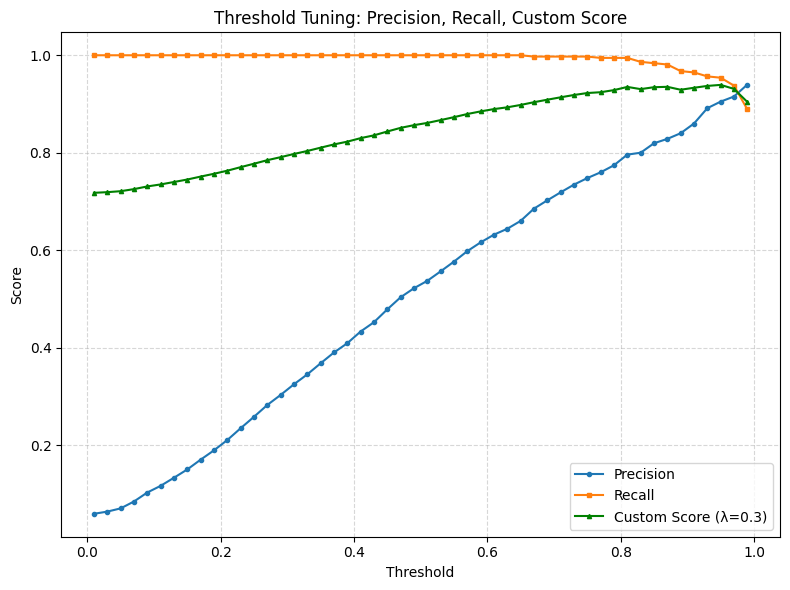

 Best Custom Score at threshold ≈ 0.95: Score = 0.939
   Precision: 0.905, Recall: 0.954


(array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
        0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
        0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
        0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
        0.89, 0.91, 0.93, 0.95, 0.97, 0.99]),
 [0.05905889884763124,
  0.06354399862235233,
  0.07015209125475286,
  0.08428506167199634,
  0.102728285077951,
  0.116403785488959,
  0.13302090843547223,
  0.15006100040666936,
  0.17012448132780084,
  0.18923076923076923,
  0.2103762827822121,
  0.23458359821996186,
  0.25804195804195806,
  0.2823259372609028,
  0.30295566502463056,
  0.3248239436619718,
  0.3451824134705332,
  0.3678963110667996,
  0.39006342494714585,
  0.4090909090909091,
  0.43309859154929575,
  0.4522058823529412,
  0.4785992217898833,
  0.5034106412005457,
  0.521923620933522,
  0.537117903930131,
  0.5565610859728507,
  0.5765625,
  0.5980551053484603,
  0.6160267111853088

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def threshold_tuning_custom(model, X, y_true, lambda_weight=0.5, title=None):
    """
    Plots precision, recall, and custom weighted score vs threshold.
    Finds threshold that maximizes custom score.
    
    Args:
        model: trained classifier with predict_proba()
        X: feature dataframe
        y_true: true labels
        lambda_weight: weight given to precision in [0,1]
    """
    # Predict probabilities
    y_proba = model.predict_proba(X)[:, 1]

    thresholds = np.linspace(0.01, 0.99, 50)
    precisions = []
    recalls = []
    custom_scores = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        custom = lambda_weight * p + (1 - lambda_weight) * r
        precisions.append(p)
        recalls.append(r)
        custom_scores.append(custom)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision', marker='o', markersize=3)
    plt.plot(thresholds, recalls, label='Recall', marker='s', markersize=3)
    plt.plot(thresholds, custom_scores, label=f'Custom Score (λ={lambda_weight})', marker='^', markersize=3, color='green')

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(title or "Threshold Tuning: Precision, Recall, Custom Score")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("threshold_tuning_custom.png", dpi=150)
    plt.show()

    # Best threshold
    best_idx = np.argmax(custom_scores)
    print(f" Best Custom Score at threshold ≈ {thresholds[best_idx]:.2f}: Score = {custom_scores[best_idx]:.3f}")
    print(f"   Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}")

    return thresholds, precisions, recalls, custom_scores, thresholds[best_idx]

threshold_tuning_custom(model, X_train, y_train, lambda_weight=0.3)


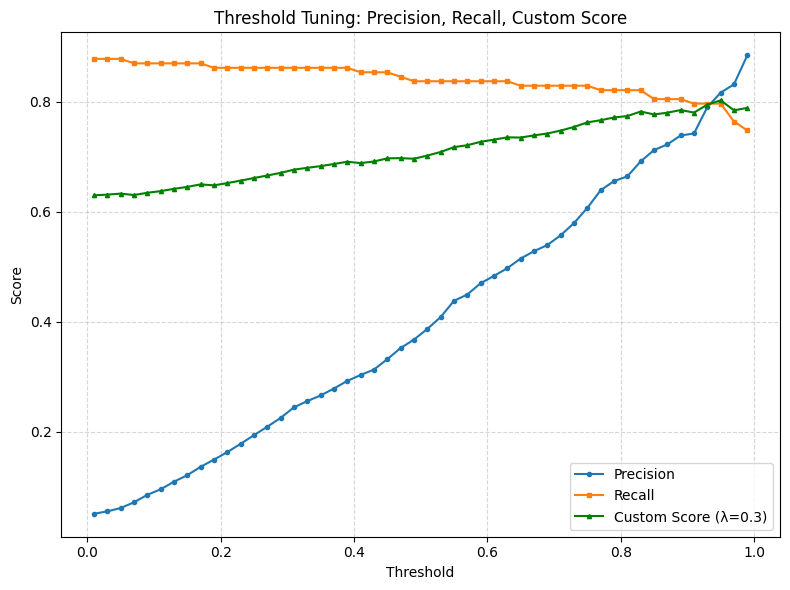

 Best Custom Score at threshold ≈ 0.95: Score = 0.803
   Precision: 0.817, Recall: 0.797


(array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
        0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
        0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
        0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
        0.89, 0.91, 0.93, 0.95, 0.97, 0.99]),
 [0.051257712387280496,
  0.05572755417956656,
  0.06167904054825814,
  0.07215104517869184,
  0.08566853482786228,
  0.09579230080572963,
  0.10951893551688843,
  0.12145289443813848,
  0.13665389527458494,
  0.1497175141242938,
  0.1633281972265023,
  0.17845117845117844,
  0.19413919413919414,
  0.20948616600790515,
  0.225531914893617,
  0.24480369515011546,
  0.2560386473429952,
  0.2663316582914573,
  0.2789473684210526,
  0.292817679558011,
  0.30346820809248554,
  0.31343283582089554,
  0.3322784810126582,
  0.3525423728813559,
  0.3678571428571429,
  0.38721804511278196,
  0.4087301587301587,
  0.43829787234042555,
  0.4497816593886463,
  0.

In [7]:
threshold_tuning_custom(model, X_test, y_test, lambda_weight=0.3)

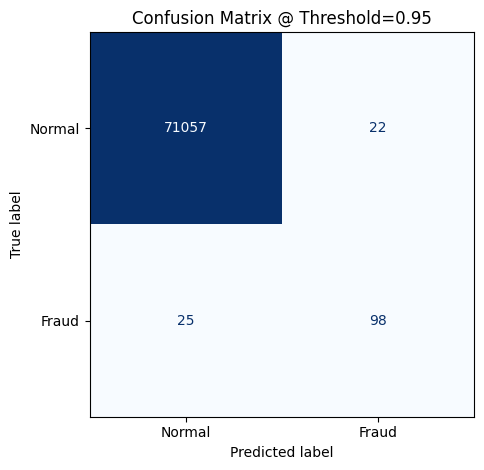


 Classification Report @ Threshold=0.95
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     71079
       Fraud       0.82      0.80      0.81       123

    accuracy                           1.00     71202
   macro avg       0.91      0.90      0.90     71202
weighted avg       1.00      1.00      1.00     71202



array([[71057,    22],
       [   25,    98]])

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_confusion_at_threshold(model, X_test, y_test, threshold=0.95, title=None):
    """
    Plots confusion matrix at given threshold and prints precision/recall/F1.
    """
    # Get predicted probabilities
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Apply threshold
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
    
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(title or f"Confusion Matrix @ Threshold={threshold}")
    plt.tight_layout()
    plt.show()
    
    # Also print classification report
    print(f"\n Classification Report @ Threshold={threshold}")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Fraud"]))

    return cm

# Usage:
# cm = plot_confusion_at_threshold(model, X_test, y_test, threshold=0.95)
plot_confusion_at_threshold(model, X_test, y_test, threshold=0.95)


d:\fraud\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


 False Positives: 22
 False Negatives: 25

 Sample False Positives:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount_Scaled,actual,pred,proba
1317,30047.0,-5.345558,5.116875,-9.270055,4.151766,-4.839258,-3.001705,-5.982505,3.892781,-2.587959,...,0.217218,-0.065900,0.197834,-0.277323,1.242472,0.281893,0.006558,0,1,0.983144
45778,99129.0,-3.141115,2.014154,-0.610409,5.946659,-1.868534,0.756737,-3.313842,0.227978,-0.937894,...,0.514926,-0.049373,-0.510364,0.442583,-0.165737,0.682784,-0.171276,0,1,0.999320



SHAP Force Plot for FP index: 1317


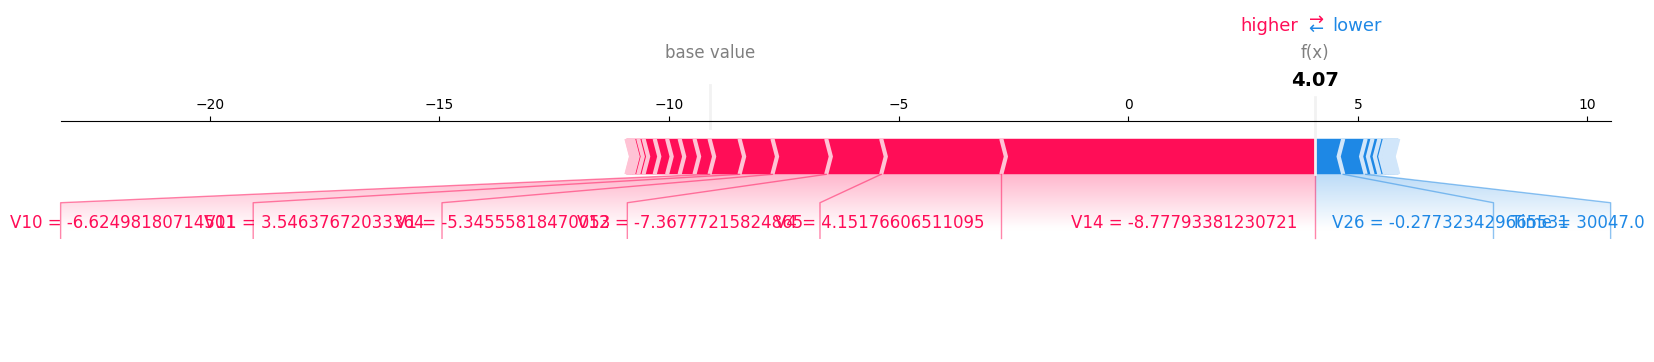


SHAP Force Plot for FP index: 45778


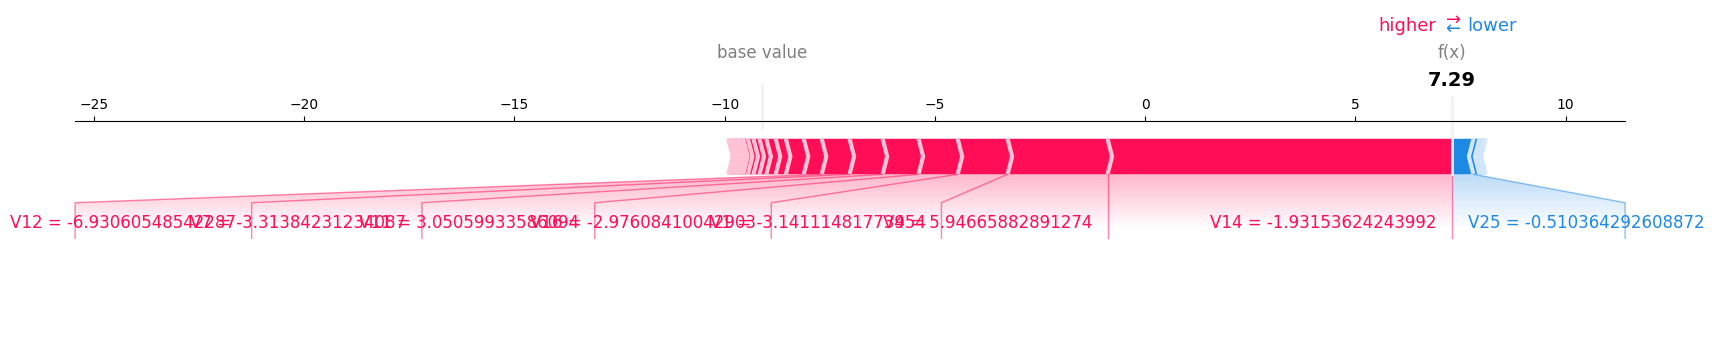


 Sample False Negatives:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount_Scaled,actual,pred,proba
24660,125612.0,1.889618,1.073099,-1.678018,4.173268,1.015516,-0.009389,-0.079706,0.064071,-0.714517,...,-0.036560,0.334306,0.147171,0.279556,0.031669,0.035883,-0.340356,1,0,0.471645
43772,30852.0,-2.830984,0.885657,1.199930,2.861292,0.321669,0.289966,1.767760,-2.451050,0.069736,...,0.172106,0.623590,-0.527114,-0.079215,-2.532445,0.311177,0.065810,1,0,0.000014



SHAP Force Plot for FN index: 24660


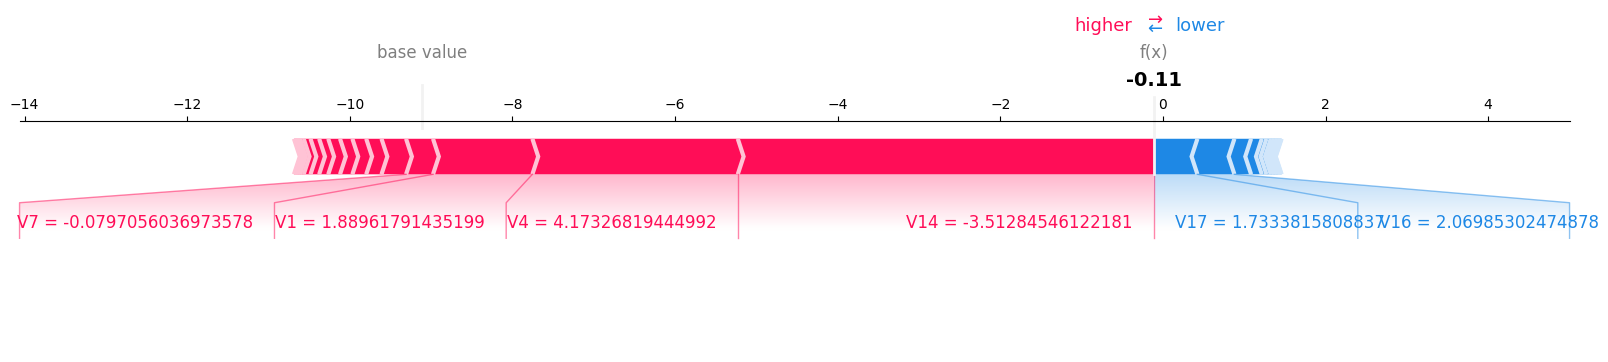


SHAP Force Plot for FN index: 43772


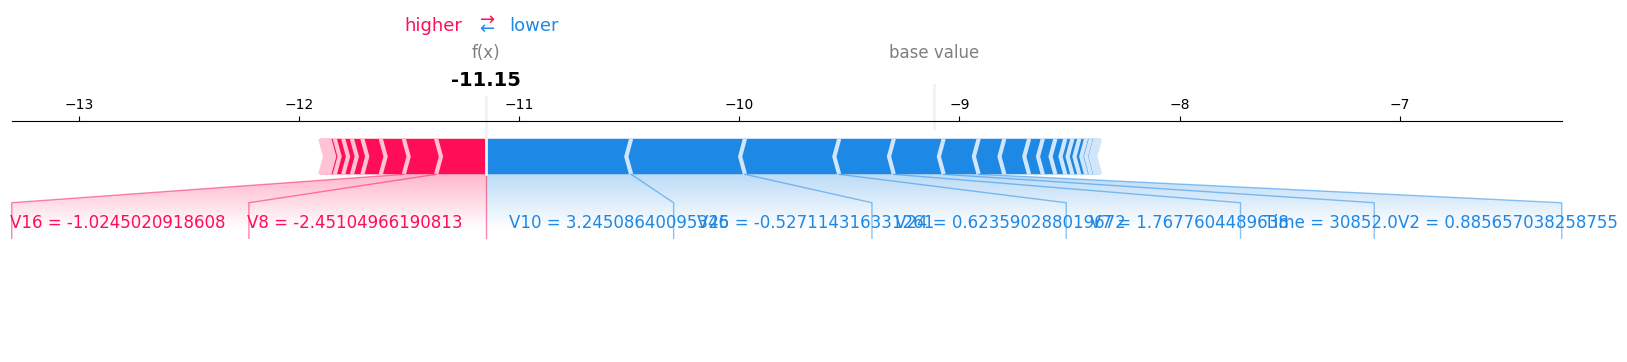

(          Time        V1        V2        V3        V4        V5        V6  \
 1317   30047.0 -5.345558  5.116875 -9.270055  4.151766 -4.839258 -3.001705   
 45778  99129.0 -3.141115  2.014154 -0.610409  5.946659 -1.868534  0.756737   
 
              V7        V8        V9  ...       V23       V24       V25  \
 1317  -5.982505  3.892781 -2.587959  ...  0.217218 -0.065900  0.197834   
 45778 -3.313842  0.227978 -0.937894  ...  0.514926 -0.049373 -0.510364   
 
             V26       V27       V28  Amount_Scaled  actual  pred     proba  
 1317  -0.277323  1.242472  0.281893       0.006558       0     1  0.983144  
 45778  0.442583 -0.165737  0.682784      -0.171276       0     1  0.999320  
 
 [2 rows x 33 columns],
            Time        V1        V2        V3        V4        V5        V6  \
 24660  125612.0  1.889618  1.073099 -1.678018  4.173268  1.015516 -0.009389   
 43772   30852.0 -2.830984  0.885657  1.199930  2.861292  0.321669  0.289966   
 
              V7        V8      

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import shap
import matplotlib.pyplot as plt

def error_analysis(model, X_test, y_test, shap_vals_test, explainer, threshold=0.95, n_samples=2):
    """
    Prints and visualizes FP & FN examples at a given threshold.
    
    Args:
        model: trained model
        X_test: test set features
        y_test: test set labels
        shap_vals_test: SHAP values for X_test
        explainer: SHAP explainer object
        threshold: probability threshold for fraud
        n_samples: number of examples to show per type
    """
    # Predict probabilities & labels
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # Build dataframe
    df_test = X_test.copy()
    df_test['actual'] = y_test.values
    df_test['pred'] = y_pred
    df_test['proba'] = y_proba

    # Identify errors
    fp = df_test[(df_test['actual']==0) & (df_test['pred']==1)]
    fn = df_test[(df_test['actual']==1) & (df_test['pred']==0)]

    print(f" False Positives: {len(fp)}")
    print(f" False Negatives: {len(fn)}")

    fp_sample = fp.sample(n=min(n_samples, len(fp)), random_state=42)
    fn_sample = fn.sample(n=min(n_samples, len(fn)), random_state=42)

    # Show FP rows
    print("\n Sample False Positives:")
    display(fp_sample)

    for idx in fp_sample.index:
        print(f"\nSHAP Force Plot for FP index: {idx}")
        shap.force_plot(
            explainer.expected_value,
            shap_vals_test[idx,:],
            X_test.iloc[idx,:],
            matplotlib=True
        )

    # Show FN rows
    print("\n Sample False Negatives:")
    display(fn_sample)

    for idx in fn_sample.index:
        print(f"\nSHAP Force Plot for FN index: {idx}")
        shap.force_plot(
            explainer.expected_value,
            shap_vals_test[idx,:],
            X_test.iloc[idx,:],
            matplotlib=True
        )

    return fp_sample, fn_sample


shap_vals_test = explainer.shap_values(X_test)
error_analysis(model, X_test, y_test, shap_vals_test, explainer, threshold=0.95, n_samples=2)

98 true‐positives, 25 false‐negatives


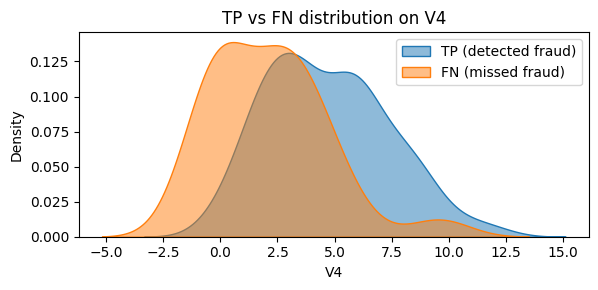

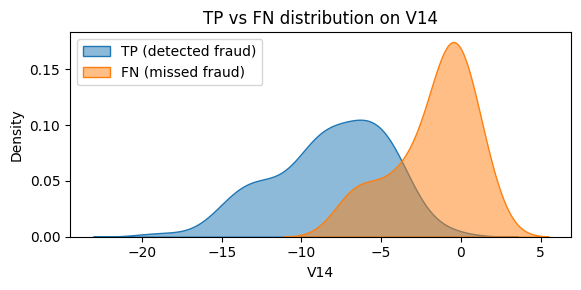

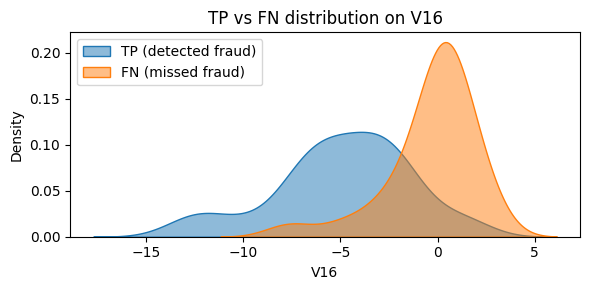

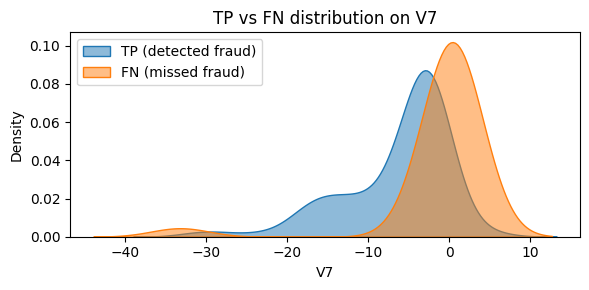

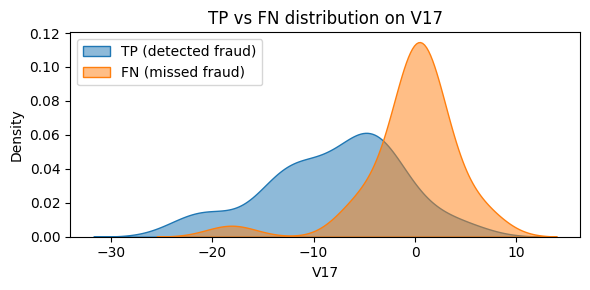

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Make sure y_test is a 1-d array
y_true = y_test.values.ravel()   # shape (n_samples,)

# 2) Get model probabilities & binary predictions at your chosen threshold
probas = model.predict_proba(X_test)[:,1]
preds  = (probas >= 0.95).astype(int)  # shape (n_samples,)

# 3) Find indices of fraud rows, then split into TP vs FN
fraud_idx = np.where(y_true == 1)[0]
tp_idx    = fraud_idx[preds[fraud_idx] == 1]
fn_idx    = fraud_idx[preds[fraud_idx] == 0]

print(f"{len(tp_idx)} true‐positives, {len(fn_idx)} false‐negatives")

# 4) Compare distributions of your top features
top_features = ['V4','V14','V16','V7','V17']  # or however you define them

for feature in top_features:
    plt.figure(figsize=(6,3))
    sns.kdeplot(
        X_test.iloc[tp_idx][feature],
        label="TP (detected fraud)", fill=True, alpha=0.5
    )
    sns.kdeplot(
        X_test.iloc[fn_idx][feature],
        label="FN (missed fraud)",  fill=True, alpha=0.5
    )
    plt.title(f"TP vs FN distribution on {feature}")
    #plt.savefig(f"tp_vs_fn_{feature}.png", dpi=150)

    plt.xlabel(feature)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"tp_vs_fn_{feature}.png", dpi=150)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'plots/amount_by_group.png'

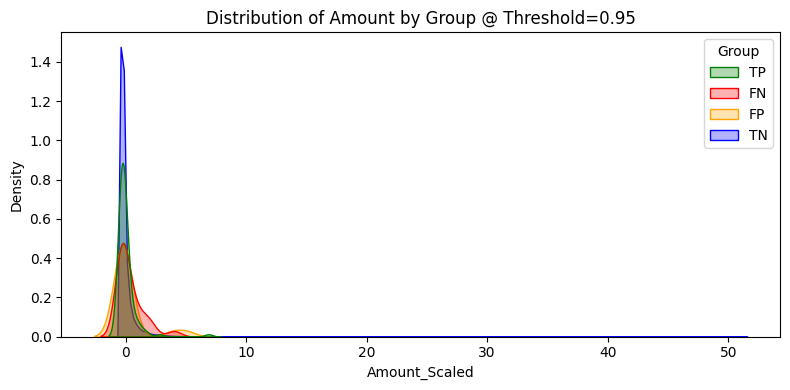

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_amount_time_distributions(model, X_test, y_test, threshold=0.95):
    """
    Plot KDE distributions of Amount and Time for TP, FP, FN, TN
    """
    # Predict probabilities & labels
    probas = model.predict_proba(X_test)[:,1]
    preds  = (probas >= threshold).astype(int)

    # Prepare masks
    y_true = y_test.values.ravel()
    y_pred = preds

    tp_idx = (y_true == 1) & (y_pred == 1)
    fn_idx = (y_true == 1) & (y_pred == 0)
    fp_idx = (y_true == 0) & (y_pred == 1)
    tn_idx = (y_true == 0) & (y_pred == 0)

    X_test_cp = X_test.copy()
    X_test_cp['True Label'] = y_true
    X_test_cp['Predicted'] = y_pred
    X_test_cp['Group'] = 'TN'
    X_test_cp.loc[tp_idx, 'Group'] = 'TP'
    X_test_cp.loc[fp_idx, 'Group'] = 'FP'
    X_test_cp.loc[fn_idx, 'Group'] = 'FN'

    groups_order = ['TP', 'FN', 'FP', 'TN']
    palette = {'TP': 'green', 'FN': 'red', 'FP': 'orange', 'TN': 'blue'}

    # Plot Amount
    plt.figure(figsize=(8,4))
    sns.kdeplot(
        data=X_test_cp, x='Amount_Scaled', hue='Group',
        common_norm=False, palette=palette, hue_order=groups_order, fill=True, alpha=0.3
    )
    plt.title(f"Distribution of Amount by Group @ Threshold={threshold}")
    plt.tight_layout()
    plt.savefig("plots/amount_by_group.png", dpi=150)
    plt.show()

    # Plot Time
    plt.figure(figsize=(8,4))
    sns.kdeplot(
        data=X_test_cp, x='Time', hue='Group',
        common_norm=False, palette=palette, hue_order=groups_order, fill=True, alpha=0.3
    )
    plt.title(f"Distribution of Time by Group @ Threshold={threshold}")
    plt.tight_layout()
    plt.savefig("plots/time_by_group.png", dpi=150)
    plt.show()

    return X_test_cp

# Example usage:
# df_with_groups = plot_amount_time_distributions(model, X_test, y_test, threshold=0.95)

plot_amount_time_distributions(model, X_test, y_test, threshold=0.95)


In [14]:
X_test.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount_Scaled'],
      dtype='object')